In [24]:
import pandas as pd

url = 'https://en.wikipedia.org/wiki/NIFTY_50'
tables = pd.read_html(url)
nifty50_df = tables[1]

tickers = [f"NSE:{t}-EQ" for t in nifty50_df['Symbol'].to_list()]

In [25]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "/workspaces/codespaces-jupyter/data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 50/50 [00:00<00:00, 59.55it/s]


In [26]:
df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

In [27]:
import talib as ta

# Calculate RSI per stock
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA20_Perc_Distance'] = (df['Close'] - df['SMA20']) / df['SMA20'] * 100

df['Entry_Price'] = df.groupby('Stock')['Close'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)

# df = df[df.Date >= '2024-01-01 05:30:00']

In [28]:
signals = (
    df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))
      .sort_values(['Date', 'SMA20_Perc_Distance']).reset_index(drop=True).dropna(subset=['Entry_Price'])
)

/tmp/ipykernel_5213/960733863.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))


In [72]:
from dataclasses import dataclass, field, asdict
from typing import List
from uuid import uuid1
from tqdm.notebook import tqdm
from copy import copy

leverage = 1
tp_perc = 7
rebalance_perc = 3
active_positions = {}
closed_positions = []
initial_capital = 200000
max_positions_num = 10

class Bank:
  initial_capital: float
  buckets: dict = {}
  ids: list = []
  residue: dict = {}
  snapshot: list = []
  bucket_usage_count: dict = {}

  def __init__(self, initial_capital, number_of_buckets = 10) -> None:
    self.initial_capital = initial_capital
    self.ids = [str(uuid1()).split('-')[0] for i in range(number_of_buckets)]
    self.buckets = dict(zip(self.ids, [initial_capital/number_of_buckets] * number_of_buckets))

  def borrow(self) -> tuple:
    if len(self.buckets) == 0:
      return None, None
    
    _df = pd.DataFrame(self.buckets.items(), columns=['key', 'amount']).sort_values('amount', ascending=True)
    key = _df.iloc[0].key
    bucket_amount = self.buckets.pop(key)

    self.bucket_usage_count[key] = self.bucket_usage_count.get(key, 0) + 1
    self._take_snapshot()
    return key, bucket_amount
  
  def save_residue(self, key, amount):
    self.residue[key] = amount

  def _take_snapshot(self):
    self.snapshot.append(copy(self.buckets))
  
  def settle(self, key, amount):
    if key not in self.ids:
      raise Exception("invalid key")
    residue = self.residue.pop(key)
    self.buckets[key] = amount + residue
    self._take_snapshot()


@dataclass
class Trade:
  capital_key: str
  entry_time: str
  entry_price: float
  quantity: int

@dataclass
class Position:
  stock: str
  entry_time: str
  avg_entry_price: float = 0.0
  quantity: int = 0
  exit_time: str = ""
  exit_price: float = 0.0
  sl: float = 0.0
  tp: float = 0.0
  trades: List[Trade] = field(default_factory=list)
  pnl: float = 0.0
  tax: float = 0.0

  def exit_margin(self):
    return (self.exit_price * self.quantity)/leverage - self.tax

  def close(self, exit_time, exit_price):
    self.exit_time = exit_time
    self.exit_price = exit_price
    if self.quantity < 0:
      print(self)
      raise Exception("Quantity can't be negative")
    self.pnl = (exit_price - self.avg_entry_price) * self.quantity
    self.calculate_taxes()

  def calculate_taxes(self):
    extry_taxes = 0
    for trade in self.trades:
      stt = abs(trade.quantity) * trade.entry_price * 0.025/100
      transaction_charges = (abs(trade.quantity) * trade.entry_price * 0.00322/100)
      gst = (stt + transaction_charges) * 18/100
      extry_taxes += stt + transaction_charges + gst

    transaction_charges = abs(self.quantity) * self.exit_price * 0.00322/100
    gst = transaction_charges * 18/100
    stamp_duty = abs(self.quantity) * self.exit_price * 0.003/100
    exit_taxes = transaction_charges + gst + stamp_duty

    self.tax = extry_taxes + exit_taxes

  def rebalance_position(self):
    total_cost = 0
    total_qty = 0
    for t in self.trades:
      total_cost += t.entry_price * t.quantity
      total_qty += t.quantity
    if total_qty == 0:
      print(self)
    self.avg_entry_price = total_cost / total_qty
    self.quantity = total_qty
    self.tp = self.avg_entry_price * (1 + tp_perc / 100)

  def add_trade(self, trade: Trade):
    self.trades.append(trade)
    self.rebalance_position()

def select_stock_for_entry(_df: pd.DataFrame):
  selected_stocks = []
  for _, row in _df.iterrows():
    if active_positions.get(row.Stock, None) is None:
      selected_stocks.append(row)
  return selected_stocks[0] if len(selected_stocks) > 0 else None


def init_new_position(k, v):
  selected_stock = select_stock_for_entry(signals[signals.Date == k])
  if selected_stock is None:
    return None
    
  key, capital = bank.borrow()
  if key is None:
    return None
      
  if selected_stock is not None:
    qty = int(capital * leverage / selected_stock.Entry_Price)
    if qty < 0:
      raise Exception("Quantity can't be negative")

    if qty == 0:
      return None
    position = Position(selected_stock.Stock, selected_stock.Entry_Time)
    trade = Trade(key, selected_stock.Entry_Time, selected_stock.Entry_Price, qty)
    position.add_trade(trade)

    bank.save_residue(key, capital - (qty * trade.entry_price) / leverage)
    return position

def avg_out_active_positions(k, v):
  global active_positions, capital_buckets
  if len(active_positions) == 0:
    return

  apdf = (
      pd.DataFrame([asdict(p) for p in active_positions.values() if p is not None]).set_index('stock')
      .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Close', 'Entry_Time', 'Entry_Price']])
  )
  apdf['perc_change'] = (apdf.Close - apdf.avg_entry_price)/apdf.avg_entry_price * 100
  rebalance_stocks = apdf[apdf.perc_change <= -rebalance_perc].sort_values('perc_change')
  if len(rebalance_stocks) == 0:
    return

  rebalance_stock = rebalance_stocks.iloc[0]
  
  key, capital = bank.borrow()
  if key is None:
    return
  
  position = active_positions[rebalance_stock.name]
  qty = position.quantity / len(position.trades)

  trade = Trade(key, rebalance_stock.Entry_Time, rebalance_stock.Entry_Price, qty)
  position.add_trade(trade)
  
  bank.save_residue(key, capital - (qty * trade.entry_price)/ leverage)

def book_profit(k, v):
  if len(active_positions) == 0:
    return

  apdf = (
      pd.DataFrame([asdict(p) for p in active_positions.values() if p is not None]).set_index('stock')
        .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['High', 'Close', 'Date']])
  )
  apdf = apdf[apdf.High >= apdf.tp]
  apdf['perc_change'] = (apdf.Close - apdf.avg_entry_price)/apdf.avg_entry_price * 100

  selected_stocks = apdf.sort_values('perc_change', ascending=False)
  if len(selected_stocks) > 0:
    selected_stock = selected_stocks.iloc[0]
    position = active_positions[selected_stock.name]
    position.close(selected_stock.Date, selected_stock.tp)
    closed_positions.append(position)
    active_positions[position.stock] = None

    exit_margin = position.exit_margin() / len(position.trades)
    for trade in position.trades:
      bank.settle(trade.capital_key, exit_margin)

def backtest():
  pb = tqdm(total=len(df.Date.unique()))
  for k, v in df.groupby('Date'):
    global active_positions
    
    position = init_new_position(k, v)
    if position is not None:
      active_positions[position.stock] = position

    else:
      avg_out_active_positions(k, v)

    book_profit(k, v)
    pb.update(1)
  pb.close()


bank = Bank(initial_capital, max_positions_num)
backtest()


  0%|          | 0/2630 [00:00<?, ?it/s]

In [73]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [74]:
import pandas as pd
from datetime import datetime

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = 200000  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in active_positions.values() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': ['Period', 'Total Trades', 'Active Position Count', 'Win Rate (%)', 'Total Profit', 'Total Tax', 'CAGR (%)'],
    'Value': [
        period,
        f"{total_trades:,}",
        f"{active_position_count:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A"
    ]
})

tearsheet

,Metric,Value
0,Period,2015-01-30 to 2025-05-15
1,Total Trades,212
2,Active Position Count,10
3,Win Rate (%),100.00
4,Total Profit,"1,010,797.59"
5,Total Tax,5893.20
6,CAGR (%),19.13


In [76]:
snapdf = pd.DataFrame(pd.DataFrame(bank.snapshot).max(), columns=['max'])
bucdf = pd.DataFrame(bank.bucket_usage_count, index=[0]).T
pd.concat([snapdf, bucdf], axis=1).rename(columns={0: 'usage_count'}).reset_index().rename(columns={'index': 'bucket_id'})

,bucket_id,max,usage_count
0,f6e24b26,147070.178160,31
1,f6e24bd0,54393.994585,16
2,f6e24c5c,44523.890539,13
3,f6e24cde,112898.588698,27
4,f6e24d60,91812.599045,24
5,f6e24dec,79514.987755,23
6,f6e24e6e,109679.851697,26
7,f6e24ee6,30328.366240,7
8,f6e24f68,507973.049998,49
9,f6e249e6,32602.080471,9


<Axes: title={'center': 'Cumulative PnL'}>

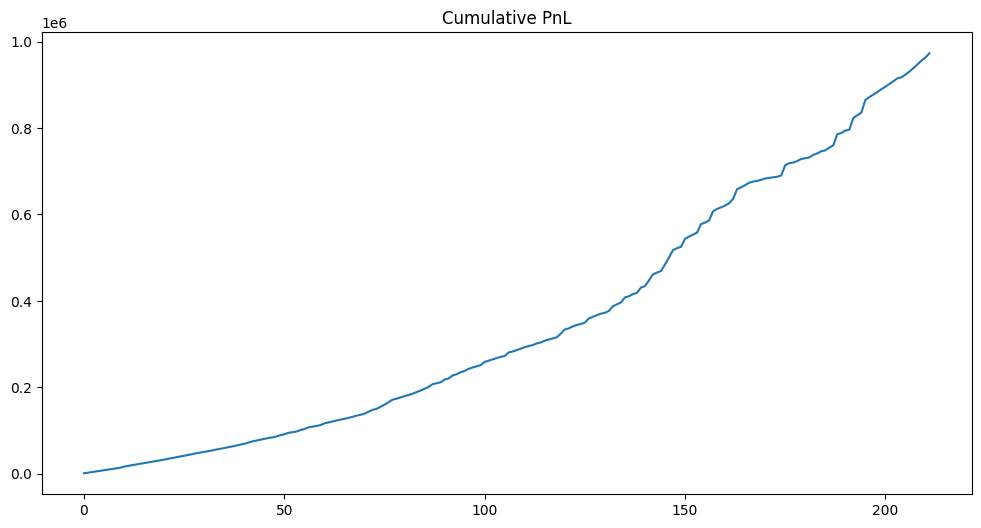

In [33]:
trades.sort_values(['exit_time']).reset_index(drop=True).pnl.cumsum().plot(title='Cumulative PnL', figsize=(12, 6))